# **Names:** \_\_\_\_\_

**EIDs:** \_\_\_\_\_

**Kaggle Team Name:** \_\_\_\_\_

# CS4487 - Course Project

Due date: Nov 30, 11:59pm

## Goal

The course project is the following:

### Predicting outcomes of schizophrenia patient

> The goal is to predict the 12-year outcomes of patients with schizophernia using 3-years of data collected after the first diagnosed episode.  The dataset contains two prediction tasks: 1) predict Suicide death within 12 year time-span; 2) predict treatment resistance to antipsychotic medication (if a patient becomes resistant to medication, than another medication Clozapine is prescribed). A good prediction model would help create early treatment models to identify potential future problems.

> There are two types of data: 1) cross-sectional data consists of patient measurements taken at a specific time point (12 years after the first diagnosis); 2) longitidual data consists of 3 years of measurements after the first episode.  For this problem, the cross-sectional data contains the class we want to predict.  The longitudinal data contains baseline information and monthly reports of symptoms and functioning for the first 3 years.


You only need to select one of these tasks (mortality or treatment resistance) for the course project. 

<span style="color:red">_**NOTE: This dataset is provided by the Psychiatry department HKU and contains some sensitive and propietary information. Do NOT redistribute this dataset to other people.**_</span>


## Groups
Projects should be done in Groups of 2.  To sign up for a group, go to Canvas and under "People", join one of the existing "Project Groups".  _For group projects, the project report must state the percentage contribution from each project member._

## Methodology
You are free to choose the methodology to solve the task.  In machine learning, it is important to use domain knowledge to help solve the problem.  Hence, instead of blindly applying the algorithms to the data you need to think about how to represent the data in a way that makes sense for the algorithm to solve the task. 


## Evaluation on Kaggle

The final evaluation will be performed on Kaggle. See the below code about the evaluation procedure.

**Note:** You can only submit 2 times per day to Kaggle!

## Project Presentation

Each project group needs to give a presentation at the end of the semester.  The presentation time is 8 minutes.  You _must_ give a presentation.

## What to hand in
You need to turn in the following things:

1. This ipynb file `CourseProject-2018.ipynb` with your source code and documentation. **You should write about all the various attempts that you make to find a good solution.**
2. Your final submission file to Kaggle.
3. The ipynb file `CourseProject-2018-final.ipynb`, which contains the code that generates the final submission file that you submit to Kaggle. **This code will be used to verify that your Kaggle submission is reproducible.**
4. Presentation slides.

Files should be uploaded to "Course Project" on Canvas.


## Grading
The marks of the assignment are distributed as follows:
- 40% - Results using various feature representations, dimensionality reduction methods, classifiers, etc.
- 20% - Trying out feature representations (e.g. adding/engineering additional features, combining features, time-series features) or methods not used in the tutorials.
- 15% - Quality of the written report.  More points for insightful observations and analysis.
- 15% - Project presentation
- 10% - Final ranking on the Kaggle test data (private leaderboard).

**Late Penalty:** 25 marks will be subtracted for each day late.

<hr>

## Getting started

The following code will get you started reading in the datasets, train a baseline classifier and evaluate it.

In [1]:
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats
random.seed(100)
import pandas as pd

D:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
D:\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
D:\Anaconda3\lib\site-packages\sklear

## Load data

The zip file contains the following files:
  - **Mortality prediction task**
    - `mortality/mortality_suicide.csv` - class labels (suicide).
    - `mortality/mortality_baseline.csv` - longitudinal data.
    - `mortality/mortality_baseline_vars.csv` - descriptions of the baseline variables.
    - `mortality/mortality_training.csv` - indices for training sets for 10 experiment trials.
    - `mortality/mortality_testing.csv` - indices for test sets for 10 experiment trials.
  - **Treatment Resistance prediction task**
    - `treatres/clozapine_tr.csv` - class label (treatment resistance).
    - `treatres/clozapine_baseline.csv` - longitudinal data.
    - `treatres/clozapine_baseline_vars.csv` - descriptions of the baseline variables
    - `treatres/treatres_training.csv` - indices for training sets for 10 experiment trials.
    - `treatres/treatres_testing.csv` - indices for testing sets for 10 experiment trials


In [2]:
# Set this variable according to the task you will do.
#   True=suicide data, False=treatment resistance data
doMortality = False

Now load the data files, join the tables according to subject ID.

In [3]:
# codes for "Missing Values", which are convereted to nan
na_values = [777, 888, 999, 99999, '777', '888', '999','99999']

if (doMortality):
    ### load the data on mortality ###################################################
    df_X = pd.read_csv('mortality/mortality_suicide.csv', na_values=na_values)
    df_L = pd.read_csv('mortality/mortality_baseline.csv', na_values=na_values)
    df_L_labels = pd.read_csv('mortality/mortality_baseline_vars.csv', na_values=na_values)

    # get the labels and HCScode (subject IDs)
    df_suic = df_X[['HCScode', 'Suicide_12']]    
    # select data_L by HCScodes in subj_suic
    df_L_part = df_L.loc[df_L['HCS_code'].isin(df_suic['HCScode'])]
    # merge data, and sort
    df = df_suic.set_index('HCScode').join(df_L_part.set_index('HCS_code'))
    # sort by HCScode
    df = df.sort_values("HCScode")
    # rename class variable name
    df.rename(index=str, columns={'Suicide_12': 'Y'}, inplace=True)
    
else:
    ### load the data on treatment resistance #########################################
    df_X = pd.read_csv('treatres/clozapine_tr.csv', na_values=na_values)
    df_L = pd.read_csv('treatres/clozapine_baseline.csv', na_values=na_values)
    df_L_labels = pd.read_csv('treatres/clozapine_baseline_vars_new.csv')

    # get HCS codes and labels
    df_tr = df_X[['HCS3', 'TR_nonTR_Inclusive']]
    # select data_L by available codes
    df_L_part = df_L.loc[df_L['HCS_code'].isin(df_tr['HCS3'])]
    # merge data
    df = df_tr.set_index('HCS3').join(df_L_part.set_index('HCS_code'))
    # remove nan values, and sort
    df = df[(df.TR_nonTR_Inclusive >= 0)].sort_values("HCS3")
    # rename class variable name
    df.rename(index=str, columns={'TR_nonTR_Inclusive': 'Y'}, inplace=True)
    df['Y'] = df['Y'].astype(int)

D:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (26,27,51,248,632,776,812,848,934,935,938,939,943,944,945,946,947,1009,1010,1011,1012,1013,1014,1016,1017,1018,1019,1020,1021,1022,1023,1024,1025,1026,1027,1029,1030,1031,1032,1033,1034,1035,1036,1037,1038,1040,1041,1042,1043,1044,1725,2033,2039,2040,2044,2160,2225,2239) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


View the processed dataframe `df`. You can see the description of the variables in the "vars" csv file.

In [4]:
print(df.shape)
df

(455, 2257)


,Y,HCS10_code,HCS10_sample,EASYp_code,Sex,Matched_pair,Yr10_FU,Yr10_sample,Filter,Filter2,...,eMeds_NA,eMeds_MIS,Adjunctive_no,SS_attempt_all,V_attempt_all,IP_last6M,DDD_last6M,M36_Fulltime,regression_datediff,regression_yr
HCS3,,,,,,,,,,,,,,,,,,,,,
CP001a,1,CP001a,1,ET30101,2,1,01/05/2012,1,1,0,...,0,0,3,0,0,0,0.09375,NaN,1625,2001
CP001b,0,NaN,0,NaN,2,1,07/27/2008,0,0,1,...,0,0,4,1,0,0,0.4000000000000001,0.0,398,1998
CP007a,0,NaN,0,ET30337,2,4,12/19/2012,0,1,0,...,0,0,3,0,0,1,1.5,0.0,2004,2002
CP011a,0,CP003a,1,ET30037,2,8,11/02/2011,1,1,0,...,8,0,3,0,0,0,,NaN,,2001
CP011b,1,AH003b,1,NaN,2,8,08/15/2010,1,0,1,...,0,0,4,1,1,0,1.1333333333333335,1.0,1148,2000
CP012b,1,CP001b,1,NaN,2,9,04/02/2011,1,0,1,...,0,0,4,0,1,0,1.1428571428571428,0.0,1378,2001
CP015a,1,NaN,0,ET30074,2,10,05/23/2011,0,1,0,...,0,0,2,0,0,0,0.5,1.0,1429,2001
CP018a,0,CP005a,1,ET30141,2,11,06/14/2012,1,1,0,...,0,0,2,0,0,0,1.4166666666666667,0.0,1816,2002
CP018b,0,CP005b,1,NaN,2,11,01/21/2011,1,0,1,...,0,0,1,0,0,0,0.4000000000000001,1.0,1307,2001


## Experiment Setup and Helper Functions

Since the dataset is relatively small, we will use 10 experiment trials with random training/test sets to do the evaluation.  In each random trial, 80% of the data is for training and the remaining 20% is for testing.

In [5]:
if (doMortality):
    # load cross-validation sets for Mortality data
    tmp = pd.read_csv('mortality/mortality_training.csv')
    train_inds = tmp.values[:,1:]
    tmp = pd.read_csv('mortality/mortality_testing.csv')
    test_inds = tmp.values[:,1:]
else:
    # load cross-validation sets for Treatment Resistance data
    tmp = pd.read_csv('treatres/treatres_training.csv')
    train_inds = tmp.values[:,1:]
    tmp = pd.read_csv('treatres/treatres_testing.csv')
    test_inds = tmp.values[:,1:]
    
print(train_inds.shape)
print(test_inds.shape)

(10, 364)
(10, 91)


We will evaluate the classifiers using ROC curves, which plot the false positive rate (FPR) versus the true positive rate (TPR) as the classifier threshold is varied. This can give a better characterization of the tradeoff between perfect detection and false detection.  The area-under-curve (AUC) measures how good the classifier is, where larger values are better.  More information can be found [here](https://en.wikipedia.org/wiki/Receiver_operating_characteristic|here:).
We will use mean AUC (over the random trials) as the evaluation criteria. An example is shown later.

The following function will run the 10 experiment trials. You need to pass the classifier function `clf` and the data matrix `X`.  The classifier function `clf` takes in the training data `trainX` and labels `trainY` and the test data `testX`, and outputs the label scores for the test data `testYscores`.  Note that this is not the prediction, but the confidence or probability of class 1.  For each trial, the ROC curve and AUC will be computed from the predicted scores.

In [6]:
# pass the classifier function clf and the data matrix X
# the function will automatically extract the training/test splits, 
# and then train and test the classifer.
def run_cv_experiment(clf, X):
    
    # NOTE: uses dataY, test_inds, train_inds from calling scope since these don't change.
    
    T = len(test_inds[0])
    allout = []

    # run CV experiment
    for t in range(10):
        # get the training/testing data
        train_index = train_inds[t]
        test_index  = test_inds[t]
        trainX = X[train_index]
        trainY = dataY[train_index]
        testX  = X[test_index]
        testY  = dataY[test_index]
    
        # your function is called here!
        testYscores = clf(trainX, trainY, testX)
         
        # compute ROC curve
        a = metrics.roc_auc_score(testY, testYscores)
        print("*** CV {}: test auc = {}".format(t, a))
    
        fpr, tpr, _ = metrics.roc_curve(testY, testYscores)
        aa = metrics.auc(fpr, tpr)  # it's the same as a
        #print(aa)
    
        # save info
        allout.append({
                'auc': a, 
                'fpr': fpr, 
                'tpr': tpr, 
                'testY': testY, 
                'testYscores': testYscores
            })
        
    # return all the information
    return(allout)

        

The following function will plot the ROC curves for each trial, as well as the average curve and standard-deviation.

In [7]:
def plotROCs(allout):
    # for interpolation
    base_fpr = linspace(0,1,101)
    tprs = []
    aucs = []
    
    # plot the individual ROCs
    plt.figure()
    plt.plot([0, 1], [0, 1], 'r:')
    for x in allout:
        plt.plot(x['fpr'], x['tpr'], 'b-', alpha=0.2)
        tpr2 = interp(base_fpr, x['fpr'], x['tpr'])
        tprs.append(tpr2)
        aucs.append(x['auc'])

    # compute the mean AUC
    meanauc = mean(aucs)
        
    tprs = array(tprs)
    # compute the mean and stddev of the ROC curve at each FPR
    tprs_mean = tprs.mean(axis=0)
    tprs_std  = tprs.std(axis=0)

    # +1/-1 standard deviation
    tprs_lower = tprs_mean-tprs_std
    tprs_upper = tprs_mean+tprs_std

    # plot
    plt.plot(base_fpr, tprs_mean, 'k-')
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)
    plt.title('mean AUC={}'.format(meanauc))
    plt.grid(True)
    plt.xlabel('FPR')
    plt.ylabel('TPR')

    return(meanauc)

The following function will save the test scores into a csv file for submission to Kaggle. You need to pass the output of the `run_cv_experiment` function.

In [8]:
# the Kaggle CSV file contains multiple columns, where each column is one experiment trial
def write_csv_kaggle(fname, allout):
    # save CSV files
    T = len(allout[0]['testYscores'])

    # make header
    ids = range(1,T+1)
    headers = ['ID']
    for r in range(1,11):
        headers.append('Run {}'.format(r))
    
    # collect data
    tmp = array(ids)
    for t in range(10):
        tmp = c_[tmp, allout[t]['testYscores']]
    
    # a prediction
    tmpdf = pd.DataFrame(tmp, columns=headers, copy=True)
    tmpdf['ID'] = tmpdf['ID'].astype(int)

    tmpdf.to_csv(fname, index=False)

## Baseline Experiment

Let's learn a baseline classifier. First, extract the features from the data frame. `dataY` contains the ground-truth labels, and `dataX` contains the matrix of feature vectors.

In [9]:
# names of features from baseline file (longitudinal data).
featnames = ['Sex', 'Age_onset', 'Ageatpresent', 'Dx_cat', 'Yrs_edu', 
             'Occup_impair', 'Smoker', 'Migration', 'life_event1', 'Disengagement', 
             'Pos_mth', 'Neg_mth', 'Aff_mth', 'Clozapine', 'totno_antipsy']

# extract data from dataframe (make a copy so we don't corrupt it later)
dataY = df['Y'].values[:]
dataX = df[featnames].values[:]
dataY.shape, dataX.shape

((455,), (455, 15))

Next, define our classifier.  There are some missing values, so we will use the simple imputer to fill in the values.

**NOTE:** for fairness, any method that requires training data (e.g., clustering, some pre-processing methods, dimensionality reduction, classification) should be called in this function.  That way the training is not performed on the test set.  Ffeature extraction that does not require training data, e.g., one-hot-encoding, can be performed outside of this function.\

In [10]:
def myclassifier(trainX, trainY, testX):
    # input is the training data (trainX,trainY) and the test data (testX)
    # for one experiment trial.
    
    # fill in the missing values with the most frequent entry
    imp = preprocessing.Imputer(missing_values=nan, strategy='most_frequent')
    trainXi = imp.fit_transform(trainX)
    testXi  = imp.transform(testX)
    
    # setup the LR classifier -- maximize AUC when doing the cross-validation
    cla = linear_model.LogisticRegressionCV(Cs=logspace(-4,4,20), cv=5, n_jobs=-1, 
                                           scoring='roc_auc')
    # fit the classifier
    cla.fit(trainXi, trainY)
    
    # predict the scores, and return them
    testYscores = cla.predict_proba(testXi)[:,1]
    return(testYscores)

Third, run on the 10 experiment trials.

In [11]:
# run the experiment, and save the output
allout = run_cv_experiment(myclassifier, dataX)

*** CV 0: test auc = 0.6499477533960292
*** CV 1: test auc = 0.6927899686520377
*** CV 2: test auc = 0.748171368861024
*** CV 3: test auc = 0.780564263322884
*** CV 4: test auc = 0.7204806687565308
*** CV 5: test auc = 0.7042842215256009
*** CV 6: test auc = 0.6556948798328108
*** CV 7: test auc = 0.7215256008359456
*** CV 8: test auc = 0.7189132706374086
*** CV 9: test auc = 0.7288401253918494


Fourth, plot the ROC curves.  The light-blue lines are the individual ROC curves, while the black line is the average curve.  The shaded gray region is one standard-deviation of the curve.  The red dotted line is the ROC curve for random chance classifier.

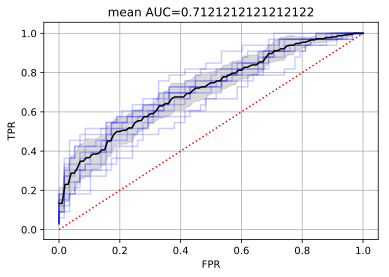

In [12]:
meanauc = plotROCs(allout)

The AUC of the baseline is 0.708 for the mortality task, and 0.713 for the treatment resistance task.

Fifth, put the data into a CSV file for submission to Kaggle.

In [13]:
write_csv_kaggle('mysub_baseline.csv', allout)

<hr>

The above classifier and feature set should be enough to get you started. You can try other classifiers or methods, as well as other features in the CSV file.  Note that some features are categorical, so some additional feature pre-processing might help.  Also, some features are time-series (labeled as "`M##_???`", where `##` are the month numbers (1-36).

A final note on the experiment setup: you shiould not select parameters by cross-validating across the 10 experiment trials, i.e., cross-validation should only be performed inside each experiment trial. Here we are interested in how well a particular method (including the parameter selection method) generalizes across different instances of the dataset.

# YOUR METHODS HERE

In [14]:
df.columns

Index(['Y', 'HCS10_code', 'HCS10_sample', 'EASYp_code', 'Sex', 'Matched_pair',
       'Yr10_FU', 'Yr10_sample', 'Filter', 'Filter2',
       ...
       'eMeds_NA', 'eMeds_MIS', 'Adjunctive_no', 'SS_attempt_all',
       'V_attempt_all', 'IP_last6M', 'DDD_last6M', 'M36_Fulltime',
       'regression_datediff', 'regression_yr'],
      dtype='object', length=2257)

In [15]:
dummyX = df['totno_antipsy'].values[:]
print(dummyX)

[ 6.  3.  4.  3.  4.  1.  3.  2.  1.  2.  1.  3.  1.  4.  3.  5.  1.  4.
  6.  1.  1.  1.  4.  3.  5. 12.  5.  4.  4.  2.  2.  3.  3.  2.  4.  3.
  1.  1.  4.  1.  1.  4.  1.  2.  5.  3.  1.  2.  2.  3.  3.  3.  4.  1.
  1.  3.  4.  1.  4.  2.  3.  2.  1.  1.  2.  3.  4.  4.  2.  1.  2.  1.
  3.  2.  1.  5.  3.  4.  3.  4.  2.  2.  1.  3.  1.  3.  3.  3.  4.  1.
  1.  1.  1.  1.  2.  0.  2.  1.  2.  2.  1.  4.  1.  3.  3.  5.  4.  6.
  2.  3.  3.  3.  4.  4.  3.  4.  2.  2.  4.  1.  4.  2.  6.  2.  2.  1.
  3.  4.  5.  2.  1.  2.  3.  2.  2.  3.  1.  3.  3.  1.  4.  1.  3.  4.
  2.  2.  1.  3.  5.  6.  3.  2.  2.  2.  1.  1.  3.  3.  2.  3.  1.  2.
  2.  3.  5.  3.  3.  8.  1.  1.  7.  2.  1.  2.  1.  2.  7.  1.  2.  1.
  2.  1.  5.  3.  3.  2.  4.  2.  2.  2.  5.  1.  2.  2.  1.  2.  1.  1.
  3.  3.  2.  6.  1.  2.  1.  1.  3.  1.  5.  3.  2.  2.  3.  5.  4.  3.
  2.  6.  3.  4.  8.  2.  2.  3.  2.  5.  2.  2.  2.  4.  2.  3.  1.  3.
  1.  5.  3.  2.  3.  2.  3.  2.  1.  1.  2.  4.  8

In [16]:
import re
#Looking at all dicrete variables which are useful, ignore = 0
# names of features from var file.
varnames = ['Variable', 'Ignore', 'Label', 'Measure', 'Value Labels']

# extract data from dataframe (make a copy so we don't corrupt it later)
labelX = df_L_labels[varnames].values[:]
for i in range(len(labelX)):
    if(labelX[i][1]==0 and not(labelX[i][0][0] == 'M' and labelX[i][0][1] >= '0' and labelX[i][0][1] <= '9')):
        print(labelX[i])

['HCS_code' 0 'HCS code (a=EI;b=SC)' 'Nominal' nan]
['Sex' 0 'Gender' 'Nominal' "{1: 'Male', 2: 'Female'}"]
['Ageat1stpre' 0 'Age (at 1st presentation)' 'Scale' nan]
['Age_onset' 0 'Age of onset' 'Scale' nan]
['DOB' 0 'Date of Birth' 'Scale' nan]
['Dx' 0 'Diagnosis' 'Nominal' nan]
['Dx_cat' 0 'Diagnostic category' 'Nominal'
 "{1: 'Schizophrenia', 3: 'ATPD', 4: 'Schizoaffective disorder', 5: 'Psychosis NOS', 6: 'BAD/Mania with psychotic symptoms', 7: 'Severe depression with psychotic symptoms'}"]
['Dx_recode1' 0 'Diagnosis in 2 groups (Non-aff/Aff)' 'Scale'
 "{1: 'Non-affective', 2: 'Affective'}"]
['Schiz' 0 'Diagnosis in 2 groups (Schiz/Non-schiz)' 'Scale'
 "{0: 'Non-schiz', 1: 'Schiz'}"]
['Dx_bad_nos' 0 'Diagnosis in 3 groups' 'Scale'
 "{1: 'BAD/DEP', 2: 'NOS/ATPD', 3: 'Schiz/Schizoaffective'}"]
['Dx_4gp' 0 nan 'Scale'
 "{1: 'Schizophrenia and schizoaffective disorder', 2: 'ATPD', 3: 'NOS', 4: 'Affective disorders'}"]
['Dx_5gp' 0 'Diagnosis in 5 groups' 'Scale'
 "{1: 'Schizophrenia an

Some of the columns contain mixed values with floats, strings and int. need to convert them to numeric types as it would cause errors.
Since the imputer uses the most frequent value because we pass both strings and numeric data types. This might not be the best strategy for all columns. The block below will try to use different values for a few columns by manually changing them

In [17]:
import math
df['High_occup_regroup'] = pd.to_numeric(df['High_occup_regroup'],errors='coerce')
sub_list = df['High_occup_regroup'].values[:]

df['Days_to_relapse'] = pd.to_numeric(df['Days_to_relapse'],errors='coerce')
for i in range(len(df)):
    if(math.isnan(df['Days_to_relapse'].iloc[i]) == True):
        df['Days_to_relapse'][i] = 0
sub_list = df['Days_to_relapse'].values[:]

df['DSH_attempt_count'] = pd.to_numeric(df['DSH_attempt_count'],errors='coerce')
sub_list = df['DSH_attempt_count'].values[:]
print(sub_list)

df['AD_dur'] = pd.to_numeric(df['AD_dur'],errors='coerce')
for i in range(len(df)):
    if(math.isnan(df['AD_dur'].iloc[i]) == True):
        df['AD_dur'][i] = 0
sub_list = df['AD_dur'].values[:]

print(sub_list)
df['BZ_dur'] = pd.to_numeric(df['BZ_dur'],errors='coerce')
for i in range(len(df)):
    if(math.isnan(df['BZ_dur'].iloc[i]) == True):
        df['BZ_dur'][i] = 0
sub_list = df['BZ_dur'].values[:]
print(sub_list)
df['MS_dur'] = pd.to_numeric(df['MS_dur'],errors='coerce')
for i in range(len(df)):
    if(math.isnan(df['MS_dur'].iloc[i]) == True):
        df['MS_dur'][i] = 0
sub_list = df['MS_dur'].values[:]
print(sub_list)


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


[ 0.  3.  0.  0.  1.  0.  0.  0.  0.  0.  0.  4.  0.  2.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  4.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  0.  0.
  0.  1.  0.  0.  0.  0.  0.  0.  0. 10.  0.  1.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  2.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  2.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.
  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[0.000e+00 0.000e+00 0.000e+00 3.690e+02 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 1.120e+02 0.000e+00 0.000e+00 2.150e+02
 0.000e+00 0.000e+00 5.250e+02 4.420e+02 0.000e+00 0.000e+00 2.870e+02
 0.000e+00 7.000e+00 0.000e+00 0.000e+00 8.800e+01 0.000e+00 0.000e+00
 0.000e+00 2.800e+01 1.990e+02 0.000e+00 0.000e+00 9.080e+02 0.000e+00
 3.500e+01 0.000e+00 0.000e+00 0.000e+00 7.110e+02 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 1.820e+02 3.500e+01 0.000e+00 0.000e+00
 1.000e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 6.940e+02
 0.000e+00 4.200e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 4.410e+02 0.000e+00 4.900e+01 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 1.090e+02 0.000e+00 0.000e+00 3.080e+02 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.047e+03 0.000e+00 0.000e+00
 1.237e+03 1.540e+02 5.600e+01 0.000e+00 0.000e+00 0.000e+00 2.800e+01
 0.000e+00 2.030e+02 0.000e+00 1.400e+01 4.900e+01 0.000e+00 3.510e+02
 0.000

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[2.190e+02 6.360e+02 7.700e+01 7.300e+01 1.160e+02 3.300e+01 4.500e+01
 5.390e+02 0.000e+00 3.780e+02 0.000e+00 1.140e+02 0.000e+00 0.000e+00
 5.300e+01 4.000e+00 7.000e+01 1.360e+02 4.600e+02 0.000e+00 0.000e+00
 0.000e+00 1.580e+02 0.000e+00 2.230e+02 7.290e+02 7.370e+02 3.110e+02
 0.000e+00 0.000e+00 2.600e+01 1.460e+02 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+01 0.000e+00
 0.000e+00 0.000e+00 8.400e+01 4.000e+00 0.000e+00 2.800e+01 0.000e+00
 1.300e+01 7.000e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.360e+02
 2.660e+02 0.000e+00 2.850e+02 0.000e+00 0.000e+00 5.300e+01 0.000e+00
 0.000e+00 5.110e+02 4.900e+01 4.980e+02 8.800e+01 7.000e+00 0.000e+00
 4.690e+02 0.000e+00 4.850e+02 0.000e+00 0.000e+00 1.000e+01 0.000e+00
 0.000e+00 2.300e+01 1.810e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 1.350e+02 9.100e+01 2.200e+01 1.960e+02 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 5.840e+02 0.000e+00 2.220e+02 1.000e+00 0.000e+00 3.800e+01
 0.000

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[ 165.  586.  263.    0.  798. 1082.    0.    0.    0.    0.    0.  856.
    0.    0.    0.    0.    0.    0.  228.    0.  301.    0.    0.    0.
    0.    7.  806.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    7.    0.    0.
    0.    0.    0.    0.    0.    0.    0.   25.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   37.    0.  327.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.  638.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.  909.    0.    0.    0.
  632.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  965.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.  207.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.   

In [18]:
# names of features from baseline file (longitudinal data).
featnames = ['Sex', 'Age_onset', 'Ageatpresent', 'Dx_cat', 'Yrs_edu', 
             'Occup_impair', 'Smoker3', 'Migration', 'life_event1', 'Disengagement', 'High_occup_regroup','DUP_days',
             'Pos_mth', 'Neg_mth', 'Aff_mth', 'Clozapine', 'totno_antipsy', 'Funct_score','SOFAS_avg', 'Total_mth_inter',
             'Days_to_relapse', 'co_sa','SS_attempt_count', 'V_attempt_count', 'DSH_attempt_count', 'SA_count']

# extract data from dataframe (make a copy so we don't corrupt it later)
dataY = df['Y'].values[:]
dataX = df[featnames].values[:]
dataY.shape, dataX.shape

((455,), (455, 26))

In [19]:
allout = run_cv_experiment(myclassifier, dataX)

*** CV 0: test auc = 0.6833855799373041
*** CV 1: test auc = 0.733019853709509
*** CV 2: test auc = 0.806687565308255
*** CV 3: test auc = 0.7978056426332288
*** CV 4: test auc = 0.7236154649947755
*** CV 5: test auc = 0.764367816091954
*** CV 6: test auc = 0.6912225705329154
*** CV 7: test auc = 0.7894461859979102
*** CV 8: test auc = 0.790491118077325
*** CV 9: test auc = 0.7769070010449322


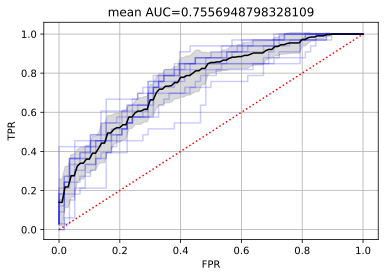

In [20]:
meanauc = plotROCs(allout)

In [21]:
write_csv_kaggle('mysub_baseline.csv', allout)

**PAROMA TIME SERIES**

### Preprocessing month timeseries columns

In [22]:
neg_symptoms_cols = [col for col in df if col.endswith("Pos")]

neg_symptoms_df = df[neg_symptoms_cols]
xr = [col[:-4] for col in neg_symptoms_cols]
xr = [int(col[1:]) for col in xr]


keyzip = zip(xr, neg_symptoms_cols)

keydict = {}
for key in keyzip:
    keydict[key[0]] = key[1]
    
print(keydict)

{1: 'M1_Pos', 2: 'M2_Pos', 3: 'M3_Pos', 4: 'M4_Pos', 5: 'M5_Pos', 6: 'M6_Pos', 7: 'M7_Pos', 8: 'M8_Pos', 9: 'M9_Pos', 10: 'M10_Pos', 11: 'M11_Pos', 12: 'M12_Pos', 13: 'M13_Pos', 14: 'M14_Pos', 15: 'M15_Pos', 16: 'M16_Pos', 17: 'M17_Pos', 18: 'M18_Pos', 19: 'M19_Pos', 20: 'M20_Pos', 21: 'M21_Pos', 22: 'M22_Pos', 23: 'M23_Pos', 24: 'M24_Pos', 25: 'M25_Pos', 26: 'M26_Pos', 27: 'M27_Pos', 28: 'M28_Pos', 29: 'M29_Pos', 30: 'M30_Pos', 31: 'M31_Pos', 32: 'M32_Pos', 33: 'M33_Pos', 34: 'M34_Pos', 35: 'M35_Pos', 36: 'M36_Pos'}


In [23]:
df_time = pd.DataFrame()

In [24]:
def label_race(row, label_root):
#     return len(row)
    timeseries_labels = ["M"+str(i)+"_{}".format(label_root) for i in range(1,37)]
    timeseries_vals = [row[label] for label in timeseries_labels]
    return timeseries_vals

In [25]:
x = df.apply(lambda x : label_race(x, "Neg"), axis=1)

#### Missing values :

In [26]:
print(x['CP001a'])
print()
print(x['SHUC242b'])

[2.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 4.0, 4.0, 2.0, 2.0, 1.0, nan, nan, nan]

[4.0, 1.0, 1.0, 1.0, 1.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


In [27]:
import re

r = re.compile('^(M[0-9]_|M[0-9][0-9]_)?')
mts_labels_list = [label for label in df if r.match(label)]
mts_labelroots_list = list(set([''.join(label.split("_")[1:]) for label in mts_labels_list]))

for label_root in mts_labelroots_list:
    df_time_label = "mts_{}".format(label_root)
    try:
        df_time[df_time_label] = df.apply(lambda x : label_race(x, label_root), axis=1)
    except KeyError as e:
        pass

In [28]:
#df_time

In [29]:
print(df_time['mts_SOFAS']['CP001a'])

[30, 40.0, 40.0, 40.0, 50.0, 70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 80.0, 80.0, 80.0, 80.0, 80.0, 30.0, 30.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, nan, nan, nan]


In [30]:
print(len(df_time.columns))
print(df_time.columns)

39
Index(['mts_sa', 'mts_default', 'mts_IP', 'mts_Funct', 'mts_AP1se', 'mts_sle2',
       'mts_timept2', 'mts_Meds2', 'mts_AP3se', 'mts_comorbid', 'mts_ssco2',
       'mts_Aff', 'mts_ssn', 'mts_SS', 'mts_AP4se', 'mts_ae', 'mts_compliance',
       'mts_ssd', 'mts_ddd', 'mts_Poscf', 'mts_se', 'mts_SOFAS', 'mts_V',
       'mts_AP2se', 'mts_ssco1', 'mts_hdose2', 'mts_dsh', 'mts_Meds',
       'mts_Negcf', 'mts_SOFAScf', 'mts_AP5se', 'mts_timept1', 'mts_Pos',
       'mts_hdose', 'mts_ect', 'mts_ssca2', 'mts_Neg', 'mts_ssca1',
       'mts_sle1'],
      dtype='object')


##### Lots of nan values in some columns, so we try to fill in for them

In [31]:
### imputing missing integer/float values in an int/float 

def interpolate_ts(row, label):
    """
    given a row of a dataframe and a column label, apply linear interpolation on ts list for that column
    """
    ts_y = row[label]
    
    res = ts_y
    """
    x : array_like
    The x-coordinates at which to evaluate the interpolated values. (the x coordinates that are nan)
    """
    ts_x = [indx for indx in range(0,36) if math.isnan(ts_y[indx])]
    
    
    """
    xp : 1-D sequence of floats
    The x-coordinates of the data points, (indices of not nan)
    """
    ts_xp = [i for i in range(0, 36) if i not in ts_x]
    

    """
    fp : 1-D sequence of float or complex
    The y-coordinates of the data points (values that are not nan), same length as xp.
    """
    ts_y = [ts_y[i] for i in ts_xp]
    
    if len(ts_x) == 0:
        return ts_y
    else:
        interpolated_values =  interp(ts_x, ts_xp, ts_y)
        i = 0
        for nan_index in ts_x:
            res[nan_index] = interpolated_values[i]
            i+=1
        return res
        
    

In [32]:
# impute NaN values in mts_Pos column in dataframe
x = df_time.apply(lambda row: interpolate_ts(row, 'mts_Neg'), axis=1)

### check that the transformation has worked properly
counter=0
for dt in x:
    if len(dt) is not 36:
        print(dt)
        counter+=1
print(counter)


0


#### Replacing missing values

In [33]:
print(x['CP001a'])
print()
print(x['SHUC242b'])

[2.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 4.0, 4.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0]

[4.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [34]:
df_time['mts_Neg'] = x

In [35]:
### Apply the same transformation to a few other columns
df_time['mts_Pos'] = df_time.apply(lambda row: interpolate_ts(row, 'mts_Pos'), axis=1)
df_time['mts_compliance'] = df_time.apply(lambda row: interpolate_ts(row, 'mts_compliance'), axis=1)

In [64]:
df_time['mts_SOFAS'] = df_time.apply(lambda row: interpolate_ts(row, 'mts_SOFAS'), axis=1)
df_time['mts_compliance'] = df_time.apply(lambda row: interpolate_ts(row, "mts_compliance"), axis=1 )
df_time['mts_Aff'] = df_time.apply(lambda row: interpolate_ts(row, "mts_Aff"), axis=1 )

### Convert the timeseries into time series deltas

In [37]:
### define a delta function to do this
def makedeltas(row, label):
    import ipdb; 
    ts = row[label]
    
    ## verify type is int or float
    for dt in ts:
        try:
            dt+=1
        except TypeError:
            print("Invalid data type for time series, returning original")
            return ts
        
    ### if it is, then run delta computation
    dts = []
    
    for i in range(1, len(ts)):
        delta = ts[i] - ts[i - 1]
        dts.append(delta)
    
    return dts
    
    

#### Pick selected columns to make deltas of 

In [38]:
df_time['dmts_Neg'] = df_time.apply(lambda row: makedeltas(row, "mts_Neg"), axis=1)

In [39]:
df_time['dmts_Pos'] = df_time.apply(lambda row: makedeltas(row, "mts_Pos"), axis=1)

In [40]:
df_time['dmts_compliance'] = df_time.apply(lambda row: makedeltas(row, "mts_compliance"), axis=1 )
df_time['dmts_SOFAS'] = df_time.apply(lambda row: makedeltas(row, "mts_SOFAS"), axis=1 )
df_time['dmts_Aff'] = df_time.apply(lambda row: makedeltas(row, "mts_Aff"), axis=1 )

In [41]:
print(len(df_time['mts_Neg'][0]))

36


**Sum the deltas to get the trend, a more positive value means that there is an increase in this particular feature. If the sum is 0 patients are getting more resistant to the medication.**

In [42]:
print(df_time['mts_Pos'][0])
print(df_time['mts_Neg'][1])
print(df_time['mts_compliance'][2])
print(df_time['mts_Pos'][3])

[7.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[3.0, 3.0, 2.0, 3.0, 3.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[5.0, 5.0, 4.0, 2.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [43]:
def sumDeltas(row, label):
    ts = row[label]
    
    ## verify type is int or float
    for dt in ts:
        try:
            dt+=1
        except TypeError:
            print("Invalid data type for time series, returning original")
            return ts
        
    val = sum(ts)
    return val

In [44]:
df_time['sum_mts_Neg'] = df_time.apply(lambda row: sumDeltas(row, "dmts_Neg"), axis=1)
df_time['sum_mts_Pos'] = df_time.apply(lambda row: sumDeltas(row, "dmts_Pos"), axis=1)
df_time['sum_mts_compliance'] = df_time.apply(lambda row: sumDeltas(row, "dmts_compliance"), axis=1)
df_time['sum_mts_SOFAS'] = df_time.apply(lambda row: sumDeltas(row, "dmts_SOFAS"), axis=1)
df_time['sum_mts_Aff'] = df_time.apply(lambda row: sumDeltas(row, "dmts_Aff"), axis=1)


In [45]:
print(df_time['sum_mts_Pos'][0])
print(df_time['sum_mts_Neg'][1])
print(df_time['sum_mts_compliance'][2])
print(df_time['sum_mts_Pos'][3])

-6.0
-2.0
0.0
-4.0


In [46]:
print(df.shape)
print(df_time.shape)

(455, 2257)
(455, 49)


In [47]:
new_df = pd.concat([df.reset_index(drop=True),df_time.reset_index(drop=True)], axis=1)

In [48]:
print(new_df.shape)

(455, 2306)


In [49]:
featnames = ['Sex', 'Age_onset', 'Ageatpresent', 'Dx_cat', 'Yrs_edu', 
             'Occup_impair', 'Smoker3', 'Migration', 'life_event1', 'Disengagement', 'High_occup_regroup','DUP_days',
             'Pos_mth', 'Neg_mth', 'Aff_mth', 'Clozapine', 'totno_antipsy', 'Funct_score','SOFAS_avg', 'Total_mth_inter',
             'Days_to_relapse', 'co_sa','SS_attempt_count', 'V_attempt_count', 'DSH_attempt_count', 'SA_count',
             'sum_mts_Pos','sum_mts_Neg','sum_mts_compliance','sum_mts_Aff']

dataX = new_df[featnames].values[:]
print(dataX.shape)

(455, 30)


In [50]:
allout = run_cv_experiment(myclassifier, dataX)

*** CV 0: test auc = 0.7136886102403344
*** CV 1: test auc = 0.7434691745036572
*** CV 2: test auc = 0.8072100313479624
*** CV 3: test auc = 0.7742946708463949
*** CV 4: test auc = 0.7424242424242425
*** CV 5: test auc = 0.7789968652037618
*** CV 6: test auc = 0.6954022988505747
*** CV 7: test auc = 0.8108672936259144
*** CV 8: test auc = 0.7601880877742946
*** CV 9: test auc = 0.7873563218390804


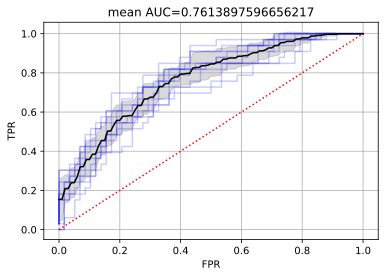

In [51]:
meanauc = plotROCs(allout)

In [52]:
write_csv_kaggle('test2_with_deltaSUM.csv', allout)

**Trying different classifiers**

In [53]:
def mySVMclassifier(trainX, trainY, testX):
    # input is the training data (trainX,trainY) and the test data (testX)
    # for one experiment trial.
    
    # fill in the missing values with the most frequent entry
    imp = preprocessing.Imputer(missing_values=nan, strategy='most_frequent')
    trainXi = imp.fit_transform(trainX)
    testXi  = imp.transform(testX)
    
    # setup the SVM classifier -- maximize AUC when doing the cross-validation
    paramgrid ={'C': logspace(-2,3,10)}
    cla = model_selection.GridSearchCV(svm.SVC(kernel='linear'),paramgrid, cv = 5, scoring='roc_auc', n_jobs=-1)

    # fit the classifier
    cla.fit(trainXi, trainY)
    
    # predict the scores, and return them
    testYscores = cla.predict_proba(testXi)[:,1]
    return(testYscores)

In [54]:
#allout = run_cv_experiment(mySVMclassifier, dataX)

In [55]:
#meanauc = plotROCs(allout)

**LSTM for time series information combined with LR for scalar values**

In [91]:
# use TensorFlow backend
%env KERAS_BACKEND=tensorflow     
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Conv2D, Flatten, Input, LSTM
from keras.preprocessing.image import ImageDataGenerator
import keras

# select as appropriate
import tensorflow
# import theano

import logging
logging.basicConfig()
import struct
random.seed(4487)
tensorflow.set_random_seed(4487)

env: KERAS_BACKEND=tensorflow


In [92]:
def plot_history(history): 
    fig, ax1 = plt.subplots()
    
    ax1.plot(history.history['loss'], 'r', label="training loss ({:.6f})".format(history.history['loss'][-1]))
    ax1.plot(history.history['val_loss'], 'r--', label="validation loss ({:.6f})".format(history.history['val_loss'][-1]))
    ax1.grid(True)
    ax1.set_xlabel('iteration')
    ax1.legend(loc="best", fontsize=9)    
    ax1.set_ylabel('loss', color='r')
    ax1.tick_params('y', colors='r')

    if 'acc' in history.history:
        ax2 = ax1.twinx()

        ax2.plot(history.history['acc'], 'b', label="training acc ({:.4f})".format(history.history['acc'][-1]))
        ax2.plot(history.history['val_acc'], 'b--', label="validation acc ({:.4f})".format(history.history['val_acc'][-1]))

        ax2.legend(loc="best", fontsize=9)
        ax2.set_ylabel('acc', color='b')        
        ax2.tick_params('y', colors='b')

In [93]:
# pass the classifier function clf and the data matrix X
# the function will automatically extract the training/test splits, 
# and then train and test the classifer.
def run_cv_experiment(clf, X_lr, X_lstm):
    
    # NOTE: uses dataY, test_inds, train_inds from calling scope since these don't change.
    
    T = len(test_inds[0])
    allout = []

    # run CV experiment
    for t in range(10):
        # get the training/testing data
        train_index = train_inds[t]
        test_index  = test_inds[t]
        trainX_lr = X_lr[train_index]
        trainX_lstm = X_lstm[train_index]
        trainY = dataY[train_index]
        testX_lr  = X_lr[test_index]
        testX_lstm  = X_lstm[test_index]
        testY  = dataY[test_index]
        
    
        # your function is called here!
        testYscores = clf(trainX_lstm,trainX_lr, trainY, testX_lstm,testX_lr)
         
        # compute ROC curve
        a = metrics.roc_auc_score(testY, testYscores)
        print("*** CV {}: test auc = {}".format(t, a))
    
        fpr, tpr, _ = metrics.roc_curve(testY, testYscores)
        aa = metrics.auc(fpr, tpr)  # it's the same as a
        #print(aa)
    
        # save info
        allout.append({
                'auc': a, 
                'fpr': fpr, 
                'tpr': tpr, 
                'testY': testY, 
                'testYscores': testYscores
            })
        
    # return all the information
    return(allout)

        

In [106]:
from sklearn.metrics import roc_curve
import ipdb
def LSTM_LR_classifier(trainX_LSTM, trainX_LR, trainY, testX_LSTM, testX_LR):
    # input is the training data (trainX,trainY) and the test data (testX)
    # for one experiment trial.
    
    # fill in the missing values with the most frequent entry
    imp = preprocessing.Imputer(missing_values=nan, strategy='most_frequent')
    trainXi = imp.fit_transform(trainX_LR)
    testXi  = imp.transform(testX_LR)
    
    # setup the nn -- maximize AUC when doing the cross-validation
    trainYb = keras.utils.np_utils.to_categorical(trainY)
    vtrainI, validI, vtrainYb, validYb = \
      model_selection.train_test_split(trainX_LSTM, trainYb, 
      train_size=0.9, test_size=0.1, random_state=4488)

    # make validation data
    validsetI = (validI, validYb)
    earlystop = keras.callbacks.EarlyStopping(
    monitor='val_loss',     # look at the validation loss
    min_delta=0.0001,       # threshold to consider as no change
    patience=5,             # stop if 5 epochs with no change
    verbose=1, mode='auto')
    
    callbacks_list = [earlystop]
    nn = Sequential()
    nn.add(LSTM(150, input_shape=(len(trainX_LSTM[0]),len(trainX_LSTM[0][0])),recurrent_dropout=0.3,dropout=0.2,return_sequences=True))
    nn.add(Dense(units=2, activation='softmax'))
    nn.compile(loss = keras.losses.categorical_crossentropy, optimizer ='adam',metrics = ['accuracy'])
    history = nn.fit(vtrainI, vtrainYb, epochs=100, batch_size = 10,
                     callbacks=callbacks_list,validation_data=validsetI,verbose=False)
    y_pred_keras = nn.predict(testX_LSTM)[:,1]
    
    plot_history(history)
    # setup the LR classifier -- maximize AUC when doing the cross-validation
    cla = linear_model.LogisticRegressionCV(Cs=logspace(-4,4,20), cv=5, n_jobs=-1, 
                                           scoring='roc_auc')
    # fit the classifier
    cla.fit(trainXi, trainY)
    
    # predict the scores, and return them
    testYscores = cla.predict_proba(testXi)[:,1]
    for i in range(len(testYscores)):
        testYscores[i] = (testYscores[i]+y_pred_keras[i])/2
    return(testYscores)

Epoch 00019: early stopping
*** CV 0: test auc = 0.719435736677116
Epoch 00017: early stopping
*** CV 1: test auc = 0.7565308254963428
Epoch 00020: early stopping
*** CV 2: test auc = 0.7539184952978056
Epoch 00011: early stopping
*** CV 3: test auc = 0.7863113897596656
Epoch 00007: early stopping
*** CV 4: test auc = 0.7554858934169278
Epoch 00025: early stopping
*** CV 5: test auc = 0.800417972831766
Epoch 00018: early stopping
*** CV 6: test auc = 0.7236154649947754
Epoch 00020: early stopping
*** CV 7: test auc = 0.7831765935214211
Epoch 00013: early stopping
*** CV 8: test auc = 0.7560083594566354
Epoch 00026: early stopping
*** CV 9: test auc = 0.7690700104493209


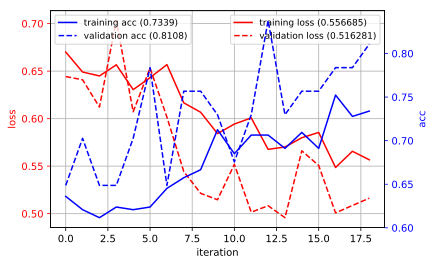

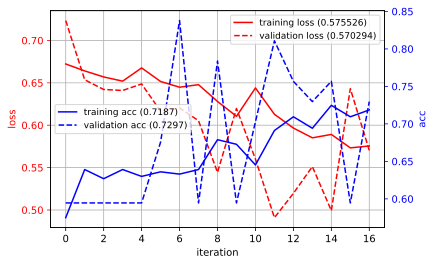

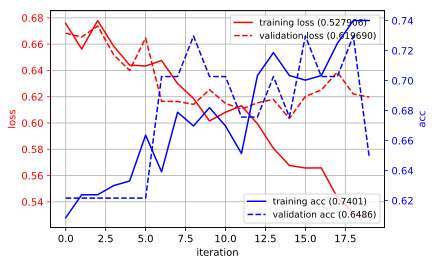

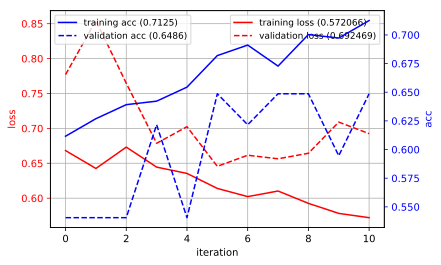

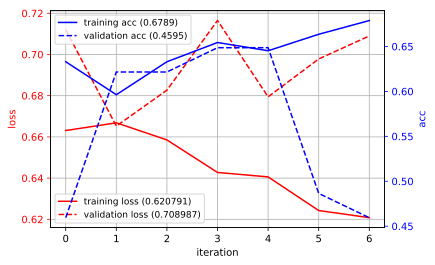

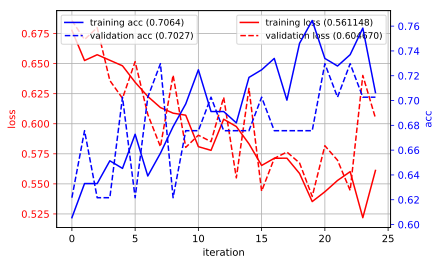

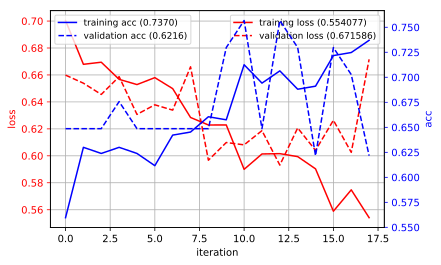

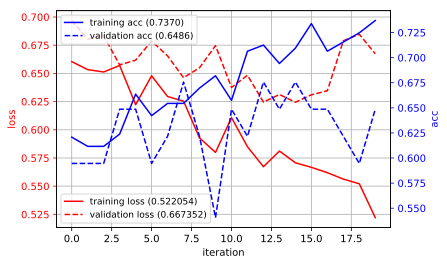

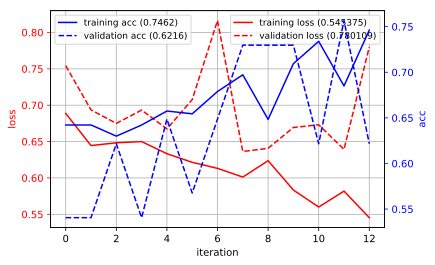

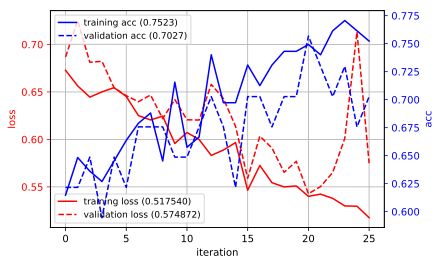

In [107]:
featnames = ['Sex', 'Age_onset', 'Ageatpresent', 'Dx_cat', 'Yrs_edu', 
             'Occup_impair', 'Smoker3', 'Migration', 'life_event1', 'Disengagement', 'High_occup_regroup','DUP_days',
             'Pos_mth', 'Neg_mth', 'Aff_mth', 'Clozapine', 'totno_antipsy', 'Funct_score','SOFAS_avg', 'Total_mth_inter',
             'Days_to_relapse', 'co_sa','SS_attempt_count', 'V_attempt_count', 'DSH_attempt_count', 'SA_count',
             'sum_mts_Pos','sum_mts_Neg','sum_mts_compliance','sum_mts_Aff']

featnames_lstm = ['mts_Pos','mts_Neg','mts_compliance','mts_Aff']
dataX_lr = new_df[featnames].values[:]
dataX_lstm = df_time[featnames_lstm].values[:]
dataX_list = dataX_lstm.tolist()
dataX_mat = stack(dataX_list, axis=0)
dataX_lstm = dataX_mat
# print(dataX_lstm[0])
# print(dataX_lstm[0][0])
# print(dataX_lstm[0][0][0])
# print(dataX_lstm.shape)
# print(dataX_lstm[0].shape)
# print(dataX_lstm[0][0].shape)
allout = run_cv_experiment(LSTM_LR_classifier, dataX_lr,dataX_lstm)

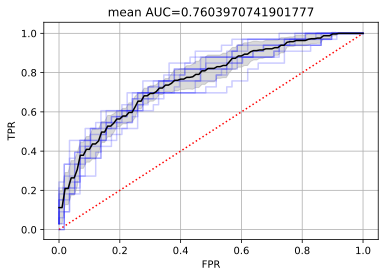

In [108]:
meanauc = plotROCs(allout)

In [83]:
write_csv_kaggle('test2_with_LR_and_LSTM.csv', allout)